## Import libraries

We will work with Pandas to load the tsv files, and scikit-learn to perform vectorization (bag of words/chars), classification, and evaluation.

Add in this cell the libraries you want to perform further experiments.

In [14]:
import pandas as pd
import numpy as np
import re
from langdetect import detect
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
#!pip install language_tool_python
import language_tool_python
from langdetect import detect, DetectorFactory
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
import seaborn as sns
import string
import json

In [2]:
data = []
with open('train.jsonl', 'r') as f:
    for line in f:
        data.append(json.loads(line.strip()))
df_train = pd.DataFrame(data)

# Take a look at the training dataframe
df_train.head()

# Limitar df_train a 10,000 registros
#df_train = df_train.sample(n=10000, random_state=42).reset_index(drop=True)


,id,text,label
0,15442,Es un tribunal de suprema instanza que forma p...,generated
1,26409,Aixó de tindrer la platgeta tant prou era un p...,human
2,12777,Doug mcadam es un científico estadista estadou...,generated
3,63467,"El president de la generalitat, carles puigdem...",generated
4,41050,"Traídas de francia, tan estrafalarias que una ...",generated


## Limpieza de datos

In [3]:
#eliminamos na y duplicados de nuestros datos 
df_train.drop_duplicates(subset='text', inplace=True)
df_train.dropna(subset=['text'], inplace=True)


visualizar de primera mano como estan los datos, distribucion de label

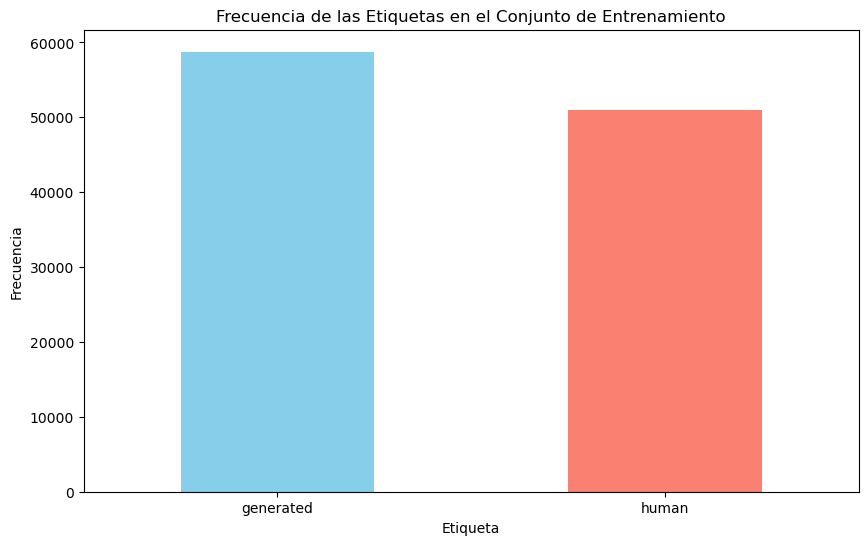

In [4]:
import matplotlib.pyplot as plt
# Contar la frecuencia de cada etiqueta
label_counts = df_train['label'].value_counts()

# Crear la gráfica
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Frecuencia de las Etiquetas en el Conjunto de Entrenamiento')
plt.xlabel('Etiqueta')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)
plt.show()

## Preporcesamiento de los datos
1- pasar a minusculas las palabras.

2-stopwords-deteccion del idioma.

3-tokenizacion.

4-lematizacion.

Se ha relaizado el proceso con estos cuatro pasos comentados y el puntaje ha bajado.

Los stopwords no nos mejoran el modelo y de igual forma pasa con la tokenizacion.

Esto nos lleva a pensar en la finalidad del modelo, que es lo que quiere predecir y que patrones necesita tener como informacion para tener mejor rendimiento, en este caso tener mayor informacion respecto al significado de la frase o significado de lo que quiere expresar en la frase no es lo mas conveniente, debemos fijarnos en la estructura del texto, como esta reformulado para poder detectar si esta escrito o no por un humano o una IA, no enfocarnos en el significado del texto en si mismo.

In [5]:
def count_punctuation(text):
    exclamations = text.count('!')
    questions = text.count('?')
    punctuation = sum([1 for char in text if char in string.punctuation])
    return exclamations, questions, punctuation

df_train[['exclamations', 'questions', 'punctuation']] = df_train['text'].apply(count_punctuation).apply(pd.Series)

In [6]:
# Función para calcular el ratio de palabras únicas en un texto
def unique_word_ratio(text):
    words = text.split()
    num_unique_words = len(set(words))
    num_total_words = len(words)
    if num_total_words == 0:  # Evitar división por cero
        return 0
    return num_unique_words / num_total_words

# Aplicar la función a la columna 'cleaned_text' del DataFrame
df_train['unique_word_ratio'] = df_train['text'].apply(unique_word_ratio)

# Mostrar los primeros registros del DataFrame actualizado
print(df_train.head())


      id                                               text      label  \
0  15442  Es un tribunal de suprema instanza que forma p...  generated   
1  26409  Aixó de tindrer la platgeta tant prou era un p...      human   
2  12777  Doug mcadam es un científico estadista estadou...  generated   
3  63467  El president de la generalitat, carles puigdem...  generated   
4  41050  Traídas de francia, tan estrafalarias que una ...  generated   

   exclamations  questions  punctuation  unique_word_ratio  
0             1          0           45           0.552743  
1             0          1            2           1.000000  
2             0          0           23           0.588571  
3             0          0           40           0.575758  
4             0          0            8           0.636364  


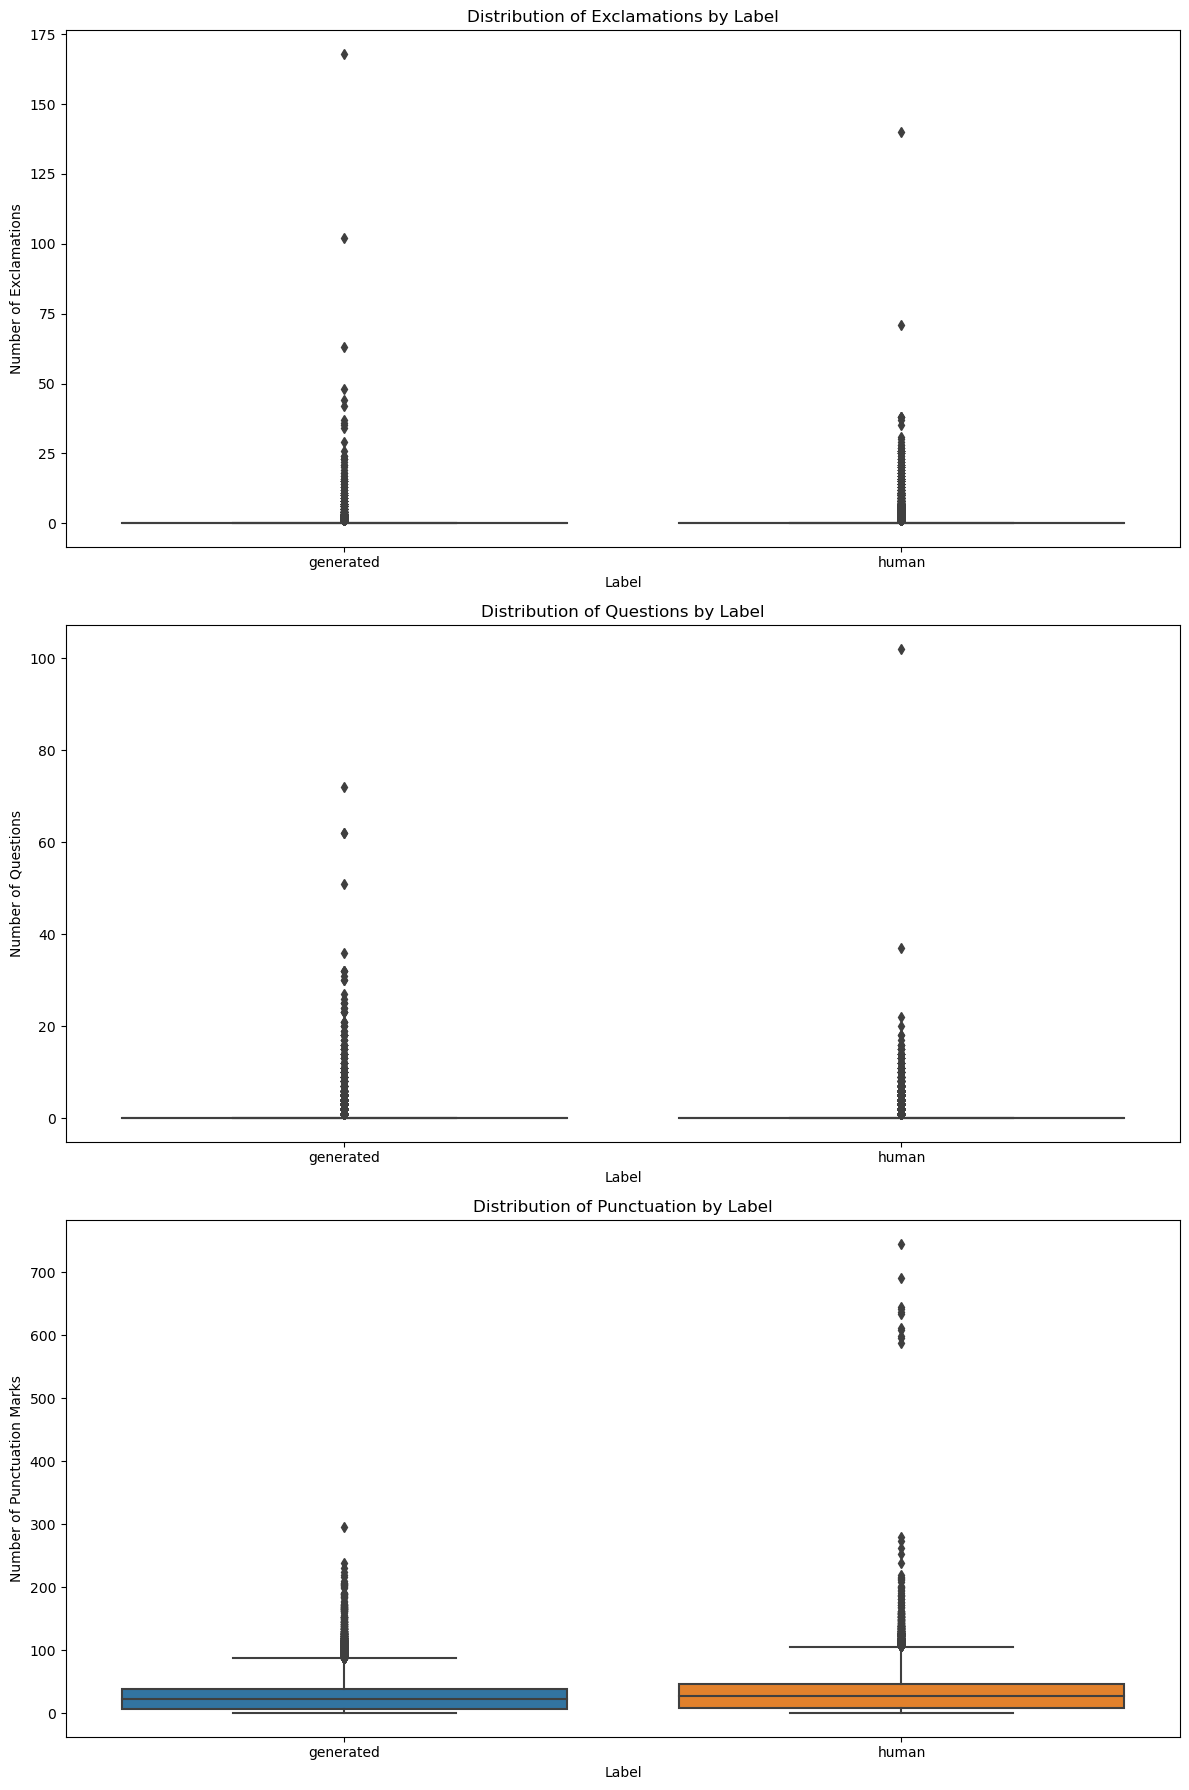

In [15]:
# Crear gráficos para exclamations, punctuation y questions
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Exclamations
sns.boxplot(ax=axes[0], x='label', y='exclamations', data=df_train)
axes[0].set_title('Distribution of Exclamations by Label')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Number of Exclamations')

# Questions
sns.boxplot(ax=axes[1], x='label', y='questions', data=df_train)
axes[1].set_title('Distribution of Questions by Label')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Number of Questions')

# Punctuation
sns.boxplot(ax=axes[2], x='label', y='punctuation', data=df_train)
axes[2].set_title('Distribution of Punctuation by Label')
axes[2].set_xlabel('Label')
axes[2].set_ylabel('Number of Punctuation Marks')

# Mostrar gráficos
plt.tight_layout()
plt.show()

In [17]:

label_dfs = {}

unique_labels = df_train['label'].unique()

for label in unique_labels:
    label_dfs[label] = df_train[df_train['label'] == label]


for label, df in label_dfs.items():
    print(f"Label: {label}, Size: {len(df)}")

Label: generated, Size: 58754
Label: human, Size: 50909


/var/folders/kf/ktcvbww96r16vv1gv5gv40jh0000gn/T/ipykernel_5485/4147939391.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[feature], label=f'Label {label}', shade=True)
/var/folders/kf/ktcvbww96r16vv1gv5gv40jh0000gn/T/ipykernel_5485/4147939391.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[feature], label=f'Label {label}', shade=True)


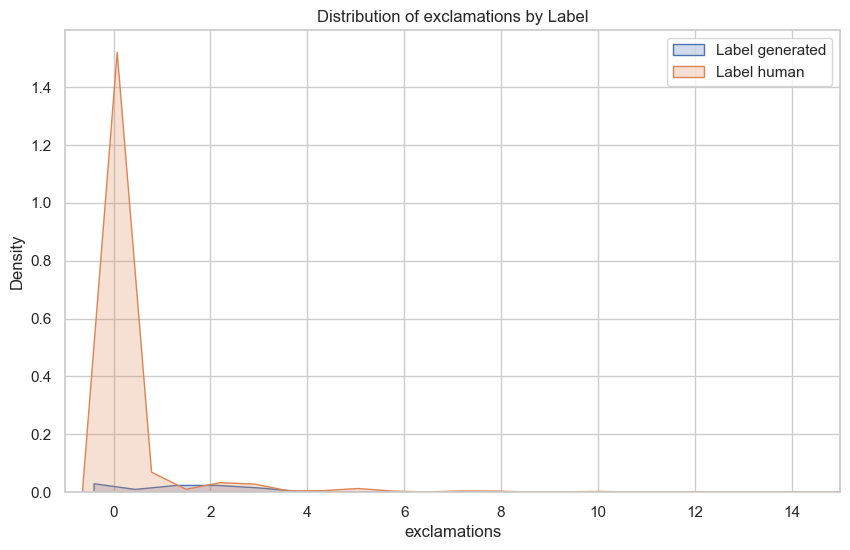

/var/folders/kf/ktcvbww96r16vv1gv5gv40jh0000gn/T/ipykernel_5485/4147939391.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[feature], label=f'Label {label}', shade=True)
/var/folders/kf/ktcvbww96r16vv1gv5gv40jh0000gn/T/ipykernel_5485/4147939391.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[feature], label=f'Label {label}', shade=True)


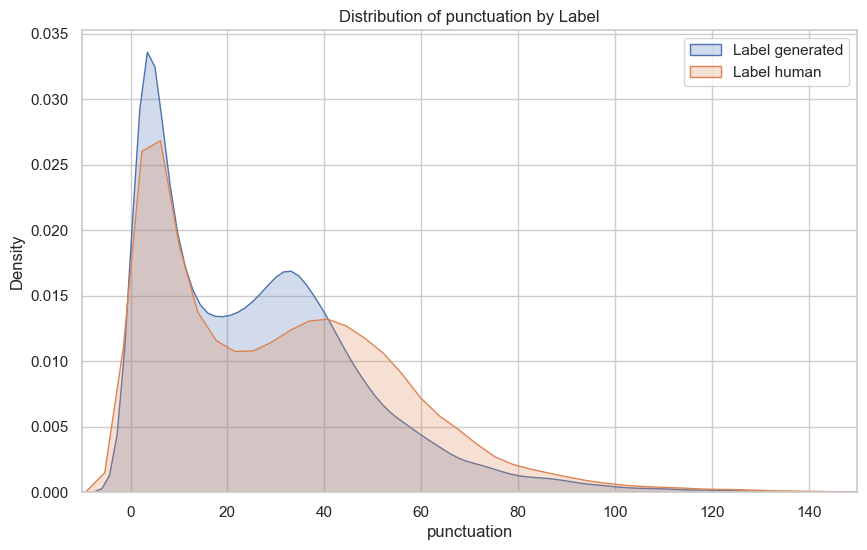

/var/folders/kf/ktcvbww96r16vv1gv5gv40jh0000gn/T/ipykernel_5485/4147939391.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[feature], label=f'Label {label}', shade=True)
/var/folders/kf/ktcvbww96r16vv1gv5gv40jh0000gn/T/ipykernel_5485/4147939391.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[feature], label=f'Label {label}', shade=True)


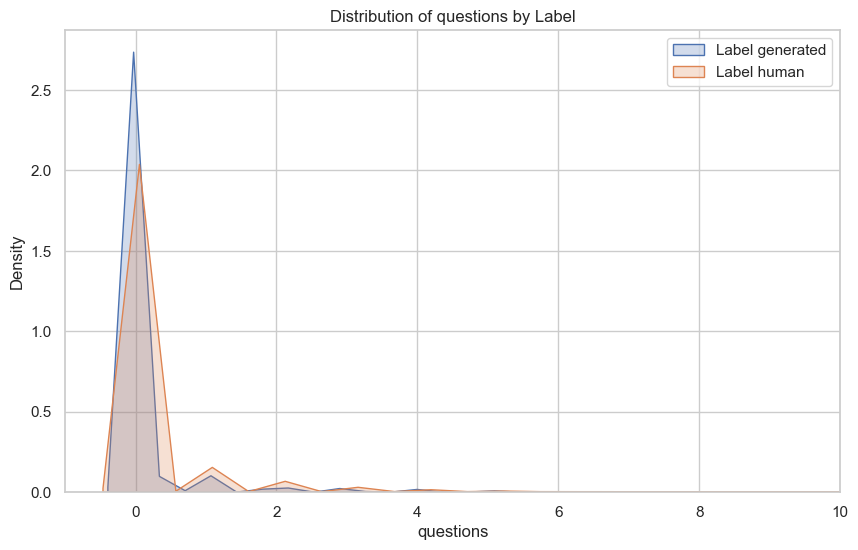

/var/folders/kf/ktcvbww96r16vv1gv5gv40jh0000gn/T/ipykernel_5485/4147939391.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[feature], label=f'Label {label}', shade=True)
/var/folders/kf/ktcvbww96r16vv1gv5gv40jh0000gn/T/ipykernel_5485/4147939391.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[feature], label=f'Label {label}', shade=True)


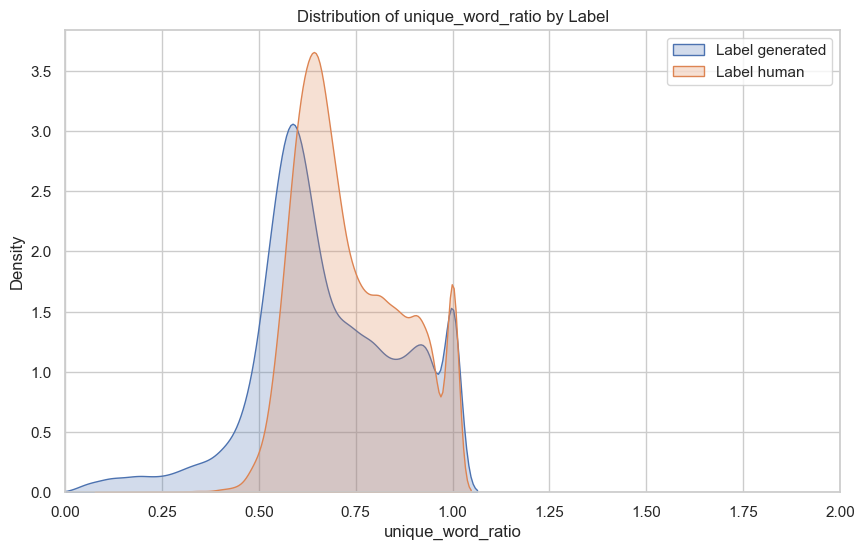

In [30]:

# Función para crear gráficos para una característica específica
def plot_feature(feature, label_dfs, xlim=None):
    plt.figure(figsize=(10, 6))
    for label, df in label_dfs.items():
        sns.kdeplot(df[feature], label=f'Label {label}', shade=True)
    plt.title(f'Distribution of {feature} by Label')
    plt.xlabel(feature)
    plt.ylabel('Density')
    if xlim:
        plt.xlim(xlim)
    plt.legend()
    plt.show()

# Establecer límites para el eje x basado en la mayoría de los datos
exclamations_xlim = (-1, 15)
punctuation_xlim = (-10, 150)
questions_xlim = (-1, 10)
word_ratio_xlim = (0, 2)
# Graficar 'exclamations'
plot_feature('exclamations', label_dfs, xlim=exclamations_xlim)

# Graficar 'punctuation'
plot_feature('punctuation', label_dfs, xlim=punctuation_xlim)

# Graficar 'questions'
plot_feature('questions', label_dfs, xlim=questions_xlim)

# Graficar 'questions'
plot_feature('unique_word_ratio', label_dfs, xlim=word_ratio_xlim)

## Vectorizacion del texto

TFDI hay que probar con mas n gramas.
Tri-gramas no mejora pero uni gramas mejor

-Por ahora el mejor es CountVectorizer con 1  n-gramas

-Word enbbedings 0.76, emperora

-Bert sentence embeddings no mejora

-Doc2Vec

-FastText peor aun que bert 

In [11]:
# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=5000), 'text'),
        ('exclamations', FunctionTransformer(lambda x: x.values.reshape(-1, 1)), 'exclamations'),
        ('questions', FunctionTransformer(lambda x: x.values.reshape(-1, 1)), 'questions'),
        ('punctuation', FunctionTransformer(lambda x: x.values.reshape(-1, 1)), 'punctuation'),
        ('unique_word_ratio', FunctionTransformer(lambda x: x.values.reshape(-1, 1)), 'unique_word_ratio')
    ],
    remainder='drop'
)

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler(with_mean=False)),  # Added scaler
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Feature and target variables
X = df_train[['text', 'exclamations', 'questions', 'punctuation', 'unique_word_ratio']]
y = df_train['label']

# Perform cross-validation
scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')

# Print results
print(f"Accuracy per fold: {scores}")
print(f"Mean accuracy: {scores.mean()}")
print(f"Standard deviation: {scores.std()}")

Accuracy per fold: [0.87872156 0.87945106 0.87849359 0.87844246 0.87917199]
Mean accuracy: 0.8788561310759555
Standard deviation: 0.000393539472432833
